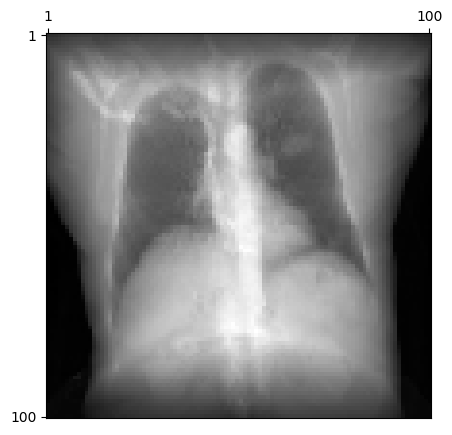

In [1]:
#| code-fold: true
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from diffdrr.data import load_example_ct
from diffdrr.drr import DRR, Registration
from diffdrr.metrics import NormalizedCrossCorrelation2d
from diffdrr.visualization import plot_drr

np.random.seed(39)

# Make the ground truth X-ray
SDR = 300.0
HEIGHT = 100
DELX = 8.0

volume, spacing = load_example_ct()
bx, by, bz = np.array(volume.shape) * np.array(spacing) / 2
true_params = {
    "sdr": SDR,
    "alpha": torch.pi,
    "beta": 0,
    "gamma": torch.pi / 2,
    "bx": bx,
    "by": by,
    "bz": bz,
}
device = "cuda" if torch.cuda.is_available() else "cpu"

drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
rotations = torch.tensor(
    [
        [
            true_params["alpha"],
            true_params["beta"],
            true_params["gamma"],
        ]
    ]
).to(device)
translations = torch.tensor(
    [
        [
            true_params["bx"],
            true_params["by"],
            true_params["bz"],
        ]
    ]
).to(device)
ground_truth = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZYX",
)

plot_drr(ground_truth)
plt.show()


In [18]:
volume.shape

(512, 512, 133)

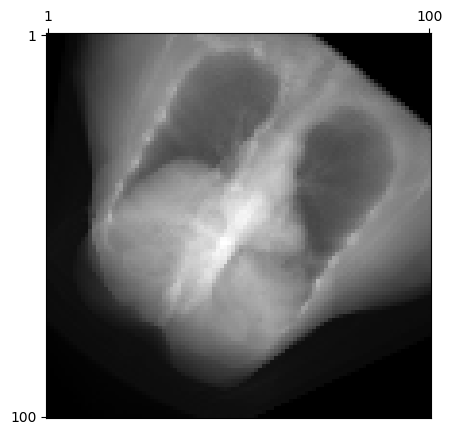

In [2]:
#| code-fold: true
# Make a random DRR
def get_initial_parameters(true_params):
    alpha = true_params["alpha"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    beta = true_params["beta"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    gamma = true_params["gamma"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    bx = true_params["bx"] + np.random.uniform(-30.0, 31.0)
    by = true_params["by"] + np.random.uniform(-30.0, 31.0)
    bz = true_params["bz"] + np.random.uniform(-30.0, 31.0)
    rotation = torch.tensor([[alpha, beta, gamma]]).to(device)
    translation = torch.tensor([[bx, by, bz]]).to(device)
    return rotation, translation


rotations, translations = get_initial_parameters(true_params)
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
with torch.no_grad():
    est = drr(
        rotations,
        translations,
        parameterization="euler_angles",
        convention="ZYX",
    )
plot_drr(est)
plt.show()

In [3]:
criterion = NormalizedCrossCorrelation2d()
criterion(ground_truth, est).item()

0.5030514001846313

In [11]:
def optimize(
    reg: Registration,
    ground_truth,
    lr_rotations=5.3e-2,
    lr_translations=7.5e1,
    momentum=0,
    dampening=0,
    n_itrs=250,
    optimizer="sgd",  # 'sgd' or `adam`
):
    criterion = NormalizedCrossCorrelation2d()
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(
            [
                {"params": [reg.rotation], "lr": lr_rotations},
                {"params": [reg.translation], "lr": lr_translations},
            ],
            momentum=momentum,
            dampening=dampening,
            maximize=True,
        )
    else:
        optimizer = torch.optim.Adam(
            [
                {"params": [reg.rotation], "lr": lr_rotations},
                {"params": [reg.translation], "lr": lr_translations},
            ],
            maximize=True,
        )

    params = []
    losses = []
    for itr in tqdm(range(n_itrs), ncols=50):
        # Save the current set of parameters
        alpha, beta, gamma = reg.get_rotation().squeeze().tolist()
        bx, by, bz = reg.get_translation().squeeze().tolist()
        params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

        # Run the optimization loop
        optimizer.zero_grad()
        estimate = reg()
        loss = criterion(ground_truth, estimate)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())

        if loss > 0.999:
            tqdm.write(f"Converged in {itr} iterations")
            break

    df = pd.DataFrame(params, columns=["alpha", "beta", "gamma", "bx", "by", "bz"])
    df["loss"] = losses
    return df

In [12]:
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZYX",
)

In [13]:
params_base = optimize(reg, ground_truth)

 55%|██████     | 138/250 [00:01<00:01, 92.18it/s]

Converged in 138 iterations


In [14]:
params_base

,alpha,beta,gamma,bx,by,bz,loss
0,3.215246,0.623918,2.241844,157.445042,186.722122,168.306390,0.503051
1,3.218231,0.621462,2.230732,157.703904,186.725018,168.078886,0.507421
2,3.218675,0.620134,2.224564,157.961572,186.649461,167.879987,0.510453
3,3.219899,0.619170,2.208573,158.216591,186.635623,167.678790,0.516247
4,3.222367,0.618365,2.194869,158.465582,186.644038,167.474419,0.521498
...,...,...,...,...,...,...,...
134,3.144144,0.002416,1.570675,177.648237,179.965193,166.248365,0.998764
135,3.144127,0.002342,1.570183,177.720592,179.969613,166.255067,0.998835
136,3.143978,0.002235,1.570566,177.790803,179.971590,166.263578,0.998902
137,3.143863,0.002134,1.570139,177.859921,179.975629,166.268545,0.998965
